In [131]:
data = "kwon/train_cascades.txt"
# measure every hour (cumulative tweets)
lag = 24
def _readFromFile(filename):
    """read all cascade from training or testing files. """
    for line in open(filename):
        i_cumulative = []
        hour = lag; i_in_period = 0; cutoff = 10000
        activations = line.strip().split(" ")
        print len(activations)
        for active in activations:
            uname, timestamp = active.split("-")
            timestamp = int(float(timestamp))/3600
            # print "T", timestamp
            if timestamp > cutoff:
                break
            if timestamp <= hour:
                i_in_period += 1
            if timestamp > hour:
                # print timestamp, hour, timestamp / lag, len(i_cumulative)
                counter = timestamp / lag - len(i_cumulative) 
                for c in range(counter):
                    i_cumulative.append(i_in_period)
                    hour += lag
                # print "H", hour
                i_in_period += 1
            # print i_cumulative 
        break
    return i_cumulative
i_measured = _readFromFile(data)
print i_measured, len(i_measured)

125
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 20, 20, 20, 21, 31, 38, 50, 51, 54, 54, 59, 63, 67, 68, 69, 69, 69, 70, 72, 73, 75, 76, 76, 76, 79, 8

Parameters([('s', <Parameter 's', value=277.91427884637005 +/- 8.87, bounds=[0.0001:inf]>), ('e', <Parameter 'e', value=0.026764258247558237 +/- 2.07, bounds=[0.0001:inf]>), ('i', <Parameter 'i', value=0.5856083354109514 +/- 0.647, bounds=[0.0001:inf]>), ('z', <Parameter 'z', value=28.62429943735506 +/- 5.26, bounds=[0.0001:inf]>), ('beta', <Parameter 'beta', value=0.02098581900673957 +/- 0.0019, bounds=[0.0001:inf]>), ('b', <Parameter 'b', value=0.004604379577709983 +/- 0.000225, bounds=[0.0001:inf]>), ('l', <Parameter 'l', value=0.9873458230034744 +/- 0.00318, bounds=[0.0001:1.0]>), ('p', <Parameter 'p', value=0.8013683784376577 +/- 1.46, bounds=[0.0001:1.0]>), ('rho', <Parameter 'rho', value=11.922465519489819 +/- 9.86, bounds=[0.0001:inf]>), ('eps', <Parameter 'eps', value=0.1970932119607971 +/- 13.9, bounds=[0.0001:inf]>)])
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 278
    # data points      = 357
    # variables        = 10
    chi-square       

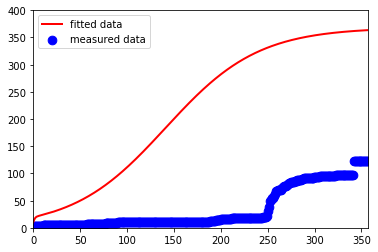

In [142]:
import numpy as np
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
import sys

def f(y, t, paras):
    """
    Your system of differential equations
    """ 
    S = y[0]
    E = y[1]
    I = y[2]
    Z = y[3]
    N = S + E + I + Z
    
    beta = paras['beta'].value
    b = paras['b'].value
    l = paras['l'].value
    p = paras['p'].value
    rho = paras['rho'].value
    eps = paras['eps'].value
    
    f0 = -beta * S * I / N - b * S * Z / N
    f1 = (1-p) * beta * S * I / N + (1-l) * b * S * Z / N - rho * E * I / N - eps * E
    f2 = p * beta * S * I / N + rho * E * I / N + eps * E
    f3 = l * b * S * Z / N
    
    return [f0, f1, f2, f3]


def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):
    """
    compute the residual between actual data and fitted data
    """
    x0 = paras['s'].value, paras['e'].value, paras['i'].value, paras['z'].value
    model = g(t, x0, paras)
    # you only have data for one of your variables
    x2_model = model[:, 2]
    return (x2_model - data).ravel()

# initial conditions
s0 = len(i_measured)
e0 = 10
i0 = 10
z0 = 10
y0 = [s0, e0, i0, z0]


# measured data
# print i_measured[len(i_measured)-1]
t_measured = np.linspace(0, len(i_measured), len(i_measured))
# print i_measured, t_measured
# print len(i_measured), len(t_measured)

val_measured = i_measured # np.array([10.000, 0.416, 0.489, 0.595, 0.506, 0.493, 0.458, 0.394, 0.335, 0.309])

plt.figure()
plt.scatter(t_measured, val_measured, marker='o', color='b', label='measured data', s=75)

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('s', value=s0, min=0.0001)
params.add('e', value=e0, min=0.0001)
params.add('i', value=i0, min=0.0001)
params.add('z', value=z0, min=0.0001)
params.add('beta', value=1.0, min=0.0001)
params.add('b', value=1.0, min=0.0001)
params.add('l', value=0.5, min=0.0001, max=1.0)
params.add('p', value=0.5, min=0.0001, max=1.0)
params.add('rho', value=1.0, min=0.0001)
params.add('eps', value=1.0, min=0.0001)
    
# fit model
result = minimize(residual, params, args=(t_measured, val_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., len(i_measured), len(i_measured)), y0, result.params)
print result.params

# plot fitted data
plt.plot(np.linspace(0., len(i_measured), len(i_measured)), data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 2])])
# display fitted statistics
report_fit(result)

RSI = ((1-result.params['p'].value) * result.params['beta'].value + (1- result.params['l'].value) * result.params['b'].value) / (result.params['rho'].value + result.params['eps'].value)
print RSI

plt.show()

NameError: name 'p' is not defined